<a href="https://colab.research.google.com/github/youngolax/AI_Module/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MAIN ASSIGNMENT 2**

In [ ]:
# Importing only necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
# Importing the file from google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Telco_Customer_Churn_Modified.csv')
X = data.drop('DroppedService', axis=1)
y = data['DroppedService'].map({'Yes': 1, 'No': 0})  # Binary target

In [ ]:
# Feature Engineering
# Converting the categorical variables to numeric
def encode_categorical(df, column):
    mapping = {val: idx for idx, val in enumerate(df[column].unique())}
    df[column] = df[column].map(mapping)
    return df

categorical_cols = ['Gender', 'HasPartner', 'HasDependents', 'HasPhoneService', 'HasMultipleLines',
                    'InternetServiceType', 'OnlineSecurityEnabled', 'OnlineBackupEnabled',
                    'DeviceProtectionEnabled', 'TechSupportEnabled', 'StreamingTVService',
                    'StreamingMoviesService', 'SubscriptionPlan', 'UsesPaperlessBilling',
                    'PaymentMethodUsed', 'District', 'MobileMoneySubscription', 'RuralSubscriber']
for col in categorical_cols:
    X = encode_categorical(X, col)


In [ ]:
# Feature Selection: Select top features based on correlation with target
numerical_features = X.select_dtypes(include=np.number).columns
correlation = X[numerical_features].corrwith(y)
selected_features = correlation.abs().sort_values(ascending=False).head(10).index
X_selected = X[selected_features].values
feature_names = selected_features.tolist()

In [ ]:
# Normalize features
X_mean = X_selected.mean(axis=0)
X_std = X_selected.std(axis=0)
X_normalized = (X_selected - X_mean) / X_std
y = y.values # coverts target to numpy array

In [ ]:
# Split dataset (manual split: 70% train, 15% validation, 15% test)
np.random.seed(42)
indices = np.random.permutation(len(y))
train_size, val_size = int(0.7 * len(y)), int(0.15 * len(y))
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, y_train = X_normalized[train_idx], y[train_idx]
X_val, y_val = X_normalized[val_idx], y[val_idx]
X_test, y_test = X_normalized[test_idx], y[test_idx]

In [ ]:
# Gradient Descent from Scratch for Logistic Regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    cost_history = []

    for _ in range(iterations):
        # Forward pass
        z = np.dot(X, weights) + bias
        y_pred = sigmoid(z)

        # Compute gradients
        error = y_pred - y
        dw = (1/n_samples) * np.dot(X.T, error)
        db = (1/n_samples) * np.sum(error)

        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Compute cost (log-loss)
        cost = -(1/n_samples) * np.sum(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        cost_history.append(cost)

    return weights, bias, cost_history

In [ ]:
# Train Logistic Regression from scratch
weights, bias, cost_history = gradient_descent(X_train, y_train, learning_rate=0.1, iterations=1000)

In [ ]:
# Predict function
def predict(X, weights, bias, threshold=0.5):
    z = np.dot(X, weights) + bias
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)

In [ ]:
# Evaluation Metrics
def evaluate(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    precision = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
    recall = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

In [ ]:
# Evaluate Logistic Regression
y_pred_train = predict(X_train, weights, bias)
y_pred_test = predict(X_test, weights, bias)
train_metrics = evaluate(y_train, y_pred_train)
test_metrics = evaluate(y_test, y_pred_test)

print("Logistic Regression (Scratch) - Train:", train_metrics)
print("Logistic Regression (Scratch) - Test:", test_metrics)

Logistic Regression (Scratch) - Train: (np.float64(0.6995943204868155), np.float64(0.6553863508178229), np.float64(0.5718503937007874), np.float64(0.6107752956636006))
Logistic Regression (Scratch) - Test: (np.float64(0.7142857142857143), np.float64(0.6578171091445427), np.float64(0.5452322738386308), np.float64(0.5962566844919786))


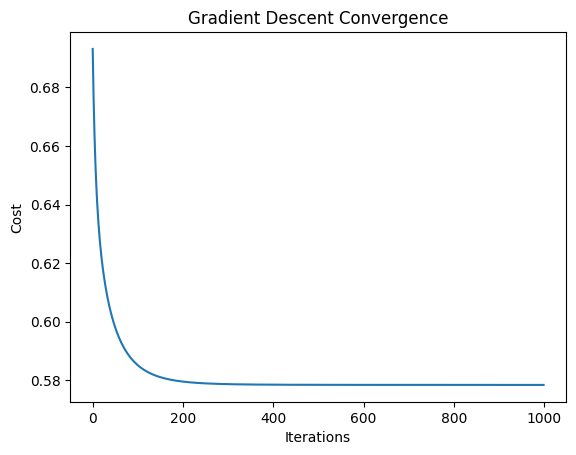

In [ ]:
# Plot cost history
plt.plot(cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.show()

In [ ]:
# Decision Tree from Scratch
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        p = np.mean(y)
        if p == 0 or p == 1:
            return 0
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    def information_gain(self, X, y, feature_idx, threshold):
        parent_entropy = self.entropy(y)
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0

        left_entropy = self.entropy(y[left_mask])
        right_entropy = self.entropy(y[right_mask])
        n = len(y)
        child_entropy = (np.sum(left_mask) / n) * left_entropy + (np.sum(right_mask) / n) * right_entropy
        return parent_entropy - child_entropy

    def best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self.information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < 2:
            return np.mean(y) > 0.5

        feature, threshold, gain = self.best_split(X, y)
        if gain == 0:
            return np.mean(y) > 0.5

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        return (feature, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_single(self, x, node):
        if not isinstance(node, tuple):
            return int(node)
        feature, threshold, left, right = node
        if x[feature] <= threshold:
            return self.predict_single(x, left)
        return self.predict_single(x, right)

    def predict(self, X):
        return np.array([self.predict_single(x, self.tree) for x in X])

In [ ]:
# Train and evaluate Decision Tree
dt = DecisionTree(max_depth=5)
dt.fit(X_train, y_train)
y_pred_dt_test = dt.predict(X_test)
dt_metrics = evaluate(y_test, y_pred_dt_test)
print("Decision Tree (Scratch) - Test:", dt_metrics)

Decision Tree (Scratch) - Test: (np.float64(0.7805108798486282), np.float64(0.7185185185185186), np.float64(0.7114914425427873), np.float64(0.7149877149877151))


In [ ]:
# Random Forest from Scratch
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, subsample_size=0.8):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_size = subsample_size
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            idx = np.random.choice(n_samples, int(n_samples * self.subsample_size), replace=True)
            X_sample, y_sample = X[idx], y[idx]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

In [ ]:
# Train and evaluate Random Forest
rf = RandomForest(n_trees=10, max_depth=5)
rf.fit(X_train, y_train)
y_pred_rf_test = rf.predict(X_test)
rf_metrics = evaluate(y_test, y_pred_rf_test)
print("Random Forest (Scratch) - Test:", rf_metrics)

Random Forest (Scratch) - Test: (np.float64(0.78240302743614), np.float64(0.7300771208226221), np.float64(0.6943765281173594), np.float64(0.7117794486215538))


In [ ]:
# Simple AdaBoost from Scratch
class SimpleAdaBoost:
    def __init__(self, n_estimators=10, max_depth=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.alphas = []

    def fit(self, X, y):
        weights = np.ones(len(y)) / len(y)
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, y)
            y_pred = tree.predict(X)
            error = np.sum(weights * (y_pred != y)) / np.sum(weights)
            if error > 0.5:
                break
            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            weights *= np.exp(-alpha * y * (2 * y_pred - 1))
            weights /= np.sum(weights)
            self.trees.append(tree)
            self.alphas.append(alpha)

    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for alpha, tree in zip(self.alphas, self.trees):
            preds += alpha * tree.predict(X)
        return (preds >= 0).astype(int)

In [ ]:
# Train and evaluate Simple AdaBoost
ab = SimpleAdaBoost(n_estimators=10, max_depth=1)
ab.fit(X_train, y_train)
y_pred_ab_test = ab.predict(X_test)
ab_metrics = evaluate(y_test, y_pred_ab_test)
print("Simple AdaBoost (Scratch) - Test:", ab_metrics)

Simple AdaBoost (Scratch) - Test: (np.float64(0.3869441816461684), np.float64(0.3869441816461684), np.float64(1.0), np.float64(0.557980900409277))


In [ ]:
# Hyperparameter Tuning for Random Forest (Manual Grid Search)
best_rf_metrics = None
best_params = None
for n_trees in [5, 10, 15]:
    for max_depth in [3, 5, 7]:
        rf = RandomForest(n_trees=n_trees, max_depth=max_depth)
        rf.fit(X_train, y_train)
        y_pred_val = rf.predict(X_val)
        val_metrics = evaluate(y_val, y_pred_val)
        if best_rf_metrics is None or val_metrics[0] > best_rf_metrics[0]:
            best_rf_metrics = val_metrics
            best_params = (n_trees, max_depth)

In [ ]:
print(f"Best Random Forest Params: n_trees={best_params[0]}, max_depth={best_params[1]}")
print("Best Random Forest Validation Metrics:", best_rf_metrics)

Best Random Forest Params: n_trees=5, max_depth=5
Best Random Forest Validation Metrics: (np.float64(0.7679924242424242), np.float64(0.6713286713286714), np.float64(0.7346938775510204), np.float64(0.7015834348355664))


In [ ]:
# Train best Random Forest on test set
best_rf = RandomForest(n_trees=best_params[0], max_depth=best_params[1])
best_rf.fit(X_train, y_train)
y_pred_best_rf_test = best_rf.predict(X_test)
best_rf_test_metrics = evaluate(y_test, y_pred_best_rf_test)
print("Tuned Random Forest - Test:", best_rf_test_metrics)

Tuned Random Forest - Test: (np.float64(0.7842951750236519), np.float64(0.7302798982188295), np.float64(0.7017114914425427), np.float64(0.7157107231920199))
